<a href="https://colab.research.google.com/github/Nsimaar99/Kaggle-Project/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/udacity/deep-learning-v2-pytorch.git

fatal: destination path 'deep-learning-v2-pytorch' already exists and is not an empty directory.


Test for CUDA

In [3]:
import torch
import numpy as np

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Load the data

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Number of subprocesses to use for dataloading
num_workers = 0
# Batch size for training, validation, and testing
batch_size = 20
# Percentage of training set to be used for validation
valid_size = 0.2

# Convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Choose the training and test dataset
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# Obtaining the training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# Specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:12<00:00, 13283272.73it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Visualize a batch of training data

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display the image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) # Convert from Tensor

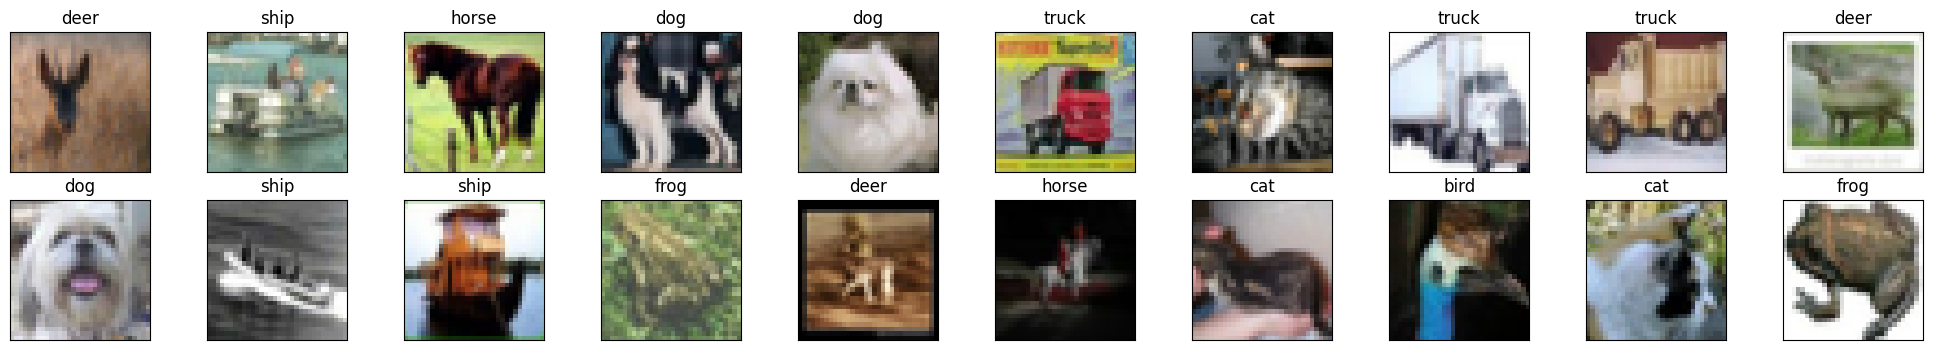

In [6]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter) # Use next(dataiter) instead of dataiter.next()
images = images.numpy() # Convert images to numpy

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# Display 20 images
for idx in np.arange(20):
    # The issue is here: 20/2 results in a float.
    # We need to ensure the result is an integer.
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

View an image in more detail

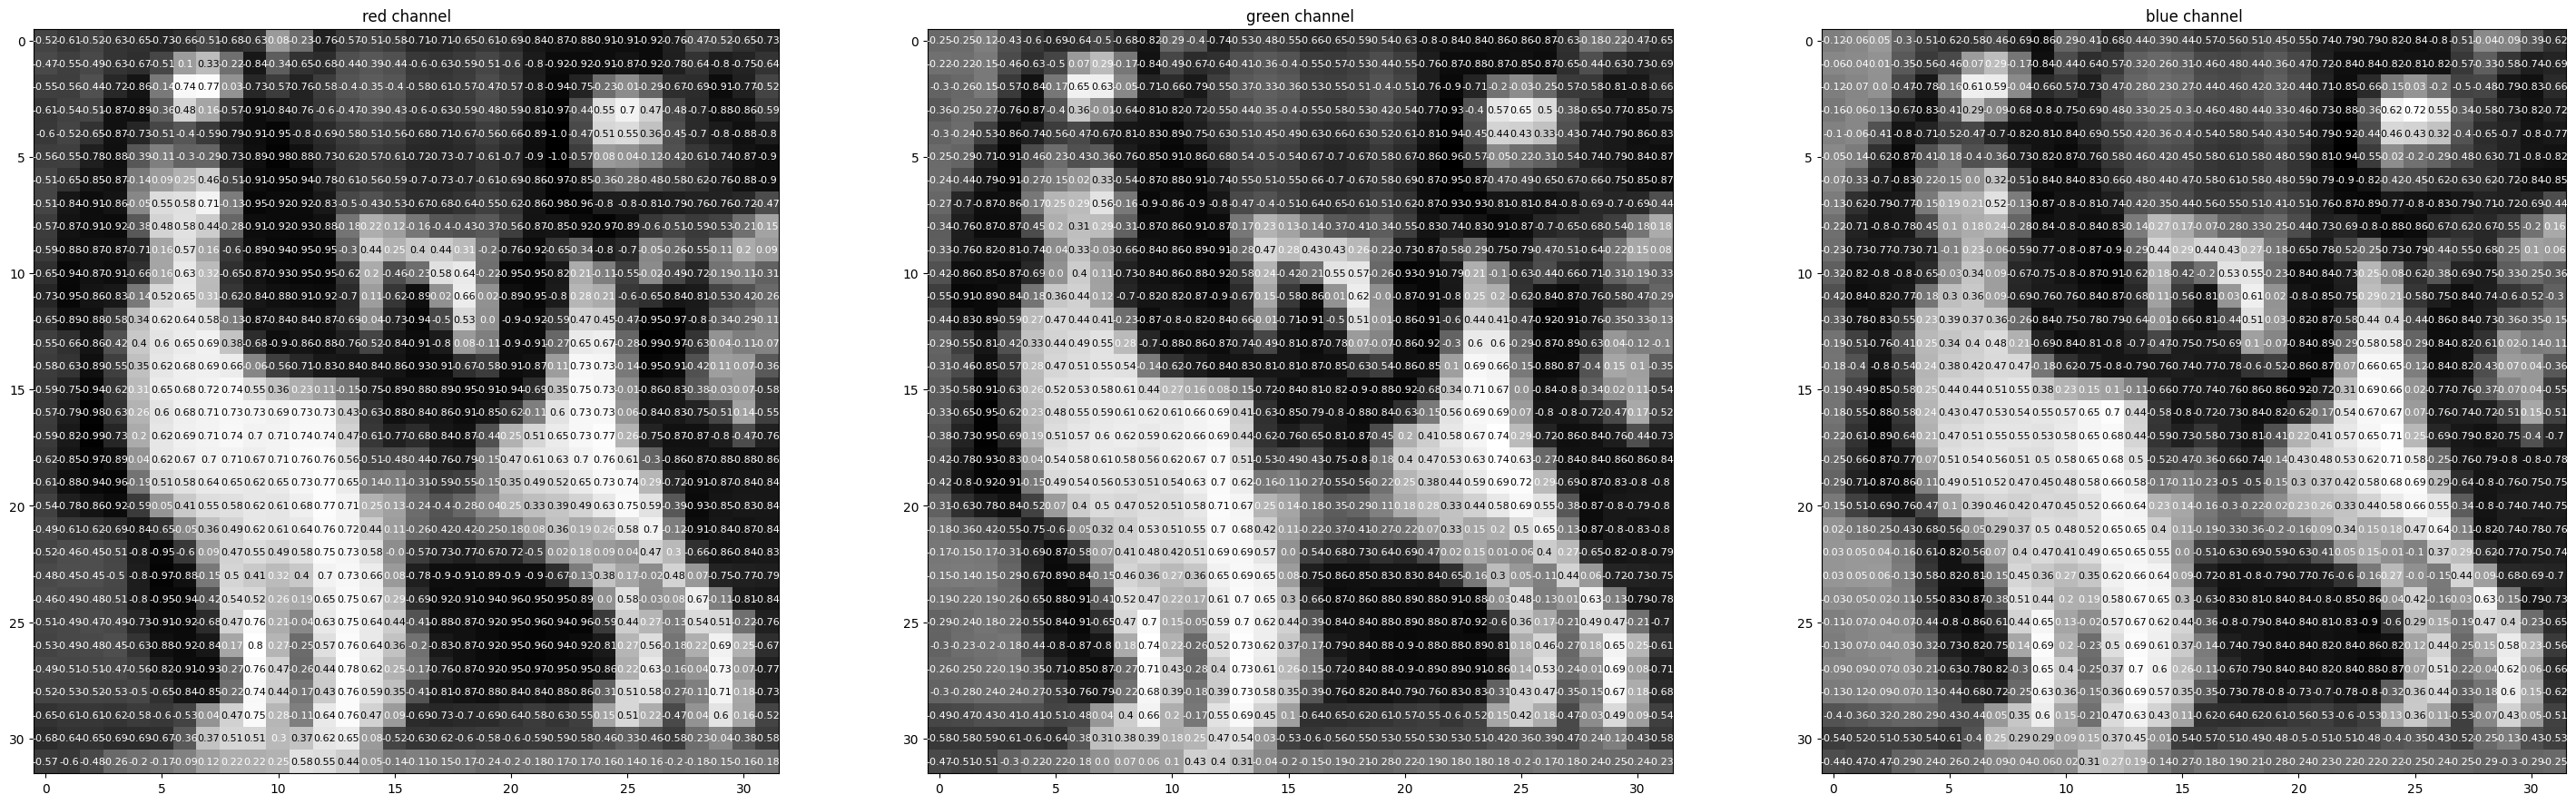

In [7]:
rgb_images = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_images.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_images[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')


Define the Network Architecture

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Define the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Input channels = 3 (RGB), output channels = 16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # Input = 16, output = 32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # Input = 32, output = 64

        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)  # Assuming the input image is 32x32
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 output classes for classification (e.g., CIFAR-10)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Pass through first convolutional layer, then apply activation function and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Pass through second convolutional layer, activation, and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Pass through third convolutional layer, activation, and pooling
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor before passing to fully connected layers
        x = x.view(-1, 64 * 4 * 4)  # Flatten (assuming input size of 32x32)

        # Pass through the first fully connected layer, then apply dropout
        x = self.dropout(F.relu(self.fc1(x)))
        # Pass through the second fully connected layer
        x = self.dropout(F.relu(self.fc2(x)))
        # Final output layer (logits)
        x = self.fc3(x)

        return x

In [9]:
# Create a complet CNN
model = Net()
print(model)
# Move the model to GPU if available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


Specify loss funtion and optimizer

In [10]:
# Specify the loss function
criterion = nn.CrossEntropyLoss()

# Specify the optimizer
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001)

Train the network

In [12]:
import torch
# Number of epochs to train the model
num_epochs = 25

# Initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Check for GPU availability and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training and validation loop
for epoch in range(1, num_epochs+1):
    # Initialize variables to monitor training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    #######################
    # Training the model   #
    #######################
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to the appropriate device (GPU or CPU)
        data, target = data.to(device), target.to(device)

        # Clear the gradients of all optimized parameters
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Update running training loss
        train_loss += loss.item() * data.size(0)  # Accumulate batch loss

    ########################
    # Validate the model    #
    ########################
    model.eval()  # Set the model to evaluation mode
    for data, target in valid_loader:
        # Move data to the appropriate device
        data, target = data.to(device), target.to(device)

        # Forward pass: compute predicted outputs
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)

        # Update running validation loss
        valid_loss += loss.item() * data.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    # Print training/validation statistics
    print(f'Epoch {epoch} \t Training Loss: {train_loss:.6f} \t Validation Loss: {valid_loss:.6f}')

    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'model_checkpoint.pth')
        valid_loss_min = valid_loss

Epoch 1 	 Training Loss: 1.234735 	 Validation Loss: 0.253020
Validation loss decreased (inf --> 0.253020). Saving model ...
Epoch 2 	 Training Loss: 0.937508 	 Validation Loss: 0.216269
Validation loss decreased (0.253020 --> 0.216269). Saving model ...
Epoch 3 	 Training Loss: 0.802989 	 Validation Loss: 0.188341
Validation loss decreased (0.216269 --> 0.188341). Saving model ...
Epoch 4 	 Training Loss: 0.714557 	 Validation Loss: 0.177023
Validation loss decreased (0.188341 --> 0.177023). Saving model ...
Epoch 5 	 Training Loss: 0.643617 	 Validation Loss: 0.176634
Validation loss decreased (0.177023 --> 0.176634). Saving model ...
Epoch 6 	 Training Loss: 0.579943 	 Validation Loss: 0.181247
Epoch 7 	 Training Loss: 0.534387 	 Validation Loss: 0.175938
Validation loss decreased (0.176634 --> 0.175938). Saving model ...
Epoch 8 	 Training Loss: 0.491244 	 Validation Loss: 0.187815
Epoch 9 	 Training Loss: 0.451888 	 Validation Loss: 0.182649
Epoch 10 	 Training Loss: 0.419855 	 Va

In [14]:
# Load the model with the lowest validation loss
model.load_state_dict(torch.load('model_checkpoint.pth'))

<ipython-input-14-508f076e5745>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_checkpoint.pth'))


<All keys matched successfully>

Test the trained network

In [20]:
import torch
import numpy as np
from collections import defaultdict

# Set the model to evaluation mode
model.eval()

# Initialize variables to track loss and accuracy
test_loss = 0.0
correct_preds = 0
total_preds = 0

# Dictionary to track per-class correct and total counts
class_correct = defaultdict(int)
class_total = defaultdict(int)

# Define loss function
criterion = nn.CrossEntropyLoss()

# No gradients needed during testing
with torch.no_grad():
    for data, target in test_loader:
        # Move data to appropriate device (CPU or GPU)
        data, target = data.to(device), target.to(device)

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)

        # Update test loss
        test_loss += loss.item() * data.size(0)

        # Get the predicted classes
        _, preds = torch.max(output, 1)

        # Update overall accuracy counts
        correct_preds += torch.sum(preds == target).item()
        total_preds += target.size(0)

        # Update per-class accuracy counts
        for i in range(len(target)):
            label = target[i].item()
            class_correct[label] += (preds[i] == target[i]).item()
            class_total[label] += 1

# Calculate the average test loss
test_loss = test_loss / len(test_loader.dataset)

# Calculate overall accuracy
overall_accuracy = correct_preds / total_preds

# Print test statistics
print(f"Average Test Loss: {test_loss:.4f}")
print(f"Overall Test Accuracy: {overall_accuracy:.2f} ({correct_preds} / {total_preds})")

# Calculate and print per-class accuracy
for i in range(len(classes)):  # Use 'classes' instead of 'class_names'
    if class_total[i] > 0:
        accuracy = class_correct[i] / class_total[i]
        print(f"Accuracy for {classes[i]}: {accuracy:.2f} ({class_correct[i]} / {class_total[i]})")


Average Test Loss: 0.8778
Overall Test Accuracy: 0.71 (7088 / 10000)
Accuracy for airplane: 0.79 (789 / 1000)
Accuracy for automobile: 0.82 (821 / 1000)
Accuracy for bird: 0.54 (544 / 1000)
Accuracy for cat: 0.41 (408 / 1000)
Accuracy for deer: 0.71 (712 / 1000)
Accuracy for dog: 0.52 (522 / 1000)
Accuracy for frog: 0.83 (833 / 1000)
Accuracy for horse: 0.82 (816 / 1000)
Accuracy for ship: 0.80 (796 / 1000)
Accuracy for truck: 0.85 (847 / 1000)


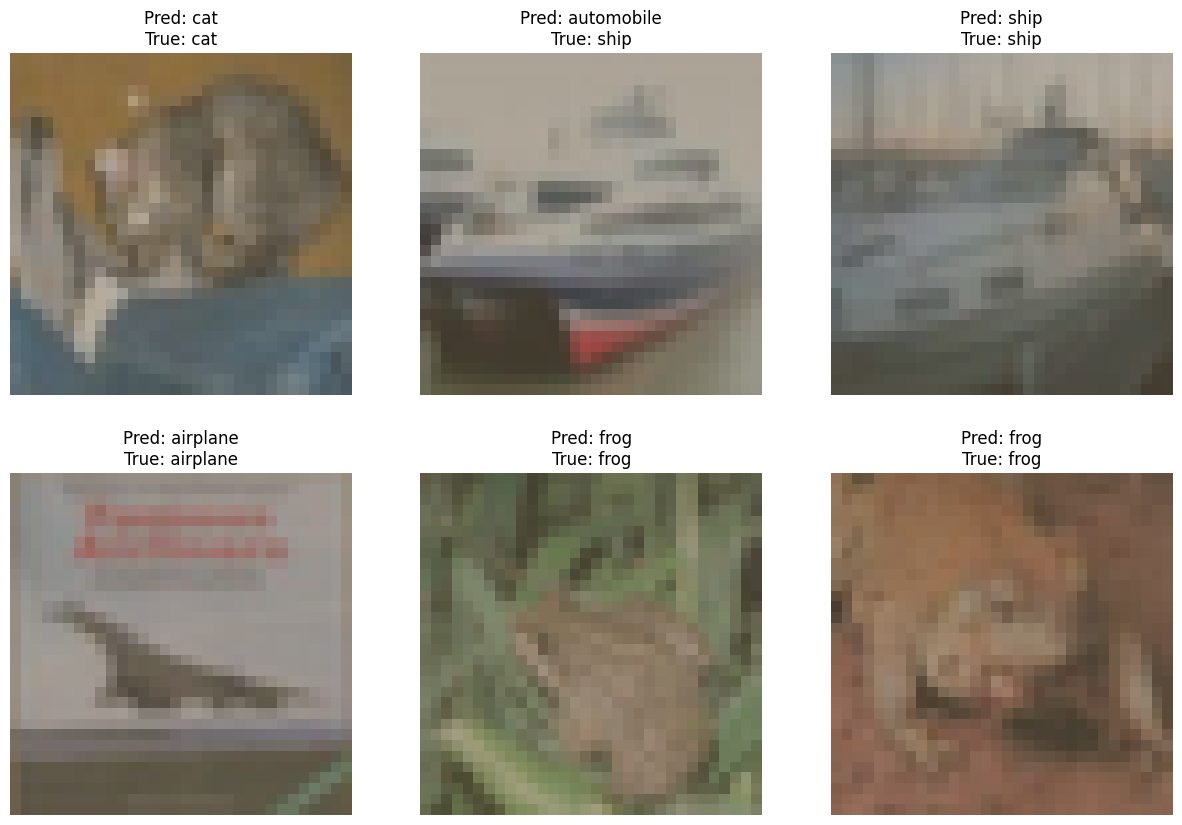

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# Function to unnormalize and show the image
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    # Unnormalize the image
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')
    return ax

# Function to visualize predictions
def visualize_predictions(model, data_loader, device, classes, num_images=6):
    model.eval()  # Set the model to evaluation mode
    images_shown = 0

    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)

            # Get model predictions
            output = model(data)
            _, preds = torch.max(output, 1)

            # Loop through images in the batch
            for j in range(data.size(0)):
                if images_shown == num_images:
                    return  # Display only the specified number of images

                ax = plt.subplot(num_images // 3, 3, images_shown + 1)
                imshow(data.cpu().data[j], ax=ax, title=f"Pred: {classes[preds[j]]}\nTrue: {classes[target[j]]}")
                images_shown += 1
        plt.tight_layout()

# Now, call the function to visualize the predictions
visualize_predictions(model, test_loader, device, classes, num_images=6)
plt.show()